# Action Recognition Model Training & Testing

In [1]:
import os
from constants import *
import numpy as np

In [ ]:
from files_io import readActionLabels, readActionMapping

action_labels = readActionLabels()

In [ ]:
action_mapping = readActionMapping()

## 1. Preprocess Data

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [5]:
features, labels = [], []

for action in action_labels:
    folderName = (action + "," + action_labels[action]).replace("/", "_")
    for npyFile in os.listdir(os.path.join(KEYPOINTS_PATH, folderName)):
        load_data = np.load(os.path.join(KEYPOINTS_PATH, folderName, npyFile))
        features.extend(load_data)
        labels.extend(np.full((load_data.shape[0], 1), int(action), dtype=int))


In [6]:
np.array(features).shape

(12200, 20, 240)

In [116]:
np.array(labels).shape

(12200, 1)

In [117]:
X = np.array(features)
X.shape

(12200, 20, 240)

In [118]:
y = to_categorical(labels).astype(int)
y.shape

(12200, 122)

In [119]:
X = X.astype(np.float32)

In [120]:
X.nbytes

234240000

In [121]:
y.nbytes

5953600

In [122]:
X_train = X
y_train = y

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [124]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9150, 20, 240)
(3050, 20, 240)
(9150, 122)
(3050, 122)


## 2. Model Compiling

In [125]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, LayerNormalization, Bidirectional, GRU, TimeDistributed, Attention
from keras.regularizers import l1, l2
from keras.callbacks import TensorBoard

In [126]:
LOG_PATH = os.path.join("log")
tb_callback = TensorBoard(log_dir=LOG_PATH)

In [127]:
modelInputSize = (X.shape[1], X.shape[2])
modelInputSize

(20, 240)

In [128]:
model = Sequential()

l2_param = 0.1

model.add(
    LSTM(
        units=128,
        input_shape=modelInputSize,
        return_sequences=True,
        activity_regularizer=l2(l=l2_param),
    )
)
model.add(LayerNormalization())

model.add(
    LSTM(
        units=64,
        return_sequences=False,
        activity_regularizer=l2(l=l2_param),
    )
)
model.add(LayerNormalization())

model.add(
    Dense(
        units=64, 
        activity_regularizer=l2(l=l2_param)
    )
)
model.add(LayerNormalization())
model.add(Activation("relu"))

model.add(
    Dense(
        units=y.shape[1],
        activation="softmax",
        activity_regularizer=l2(l=l2_param),
    )
)

In [132]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

## 3. Model Training

In [133]:
# Model training
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
286/286 [==============================] - 10s 24ms/step - loss: 5.0816 - accuracy: 0.1357 - categorical_accuracy: 0.1357
Epoch 2/30
286/286 [==============================] - 8s 28ms/step - loss: 2.9079 - accuracy: 0.4528 - categorical_accuracy: 0.4528
Epoch 3/30
286/286 [==============================] - 5s 18ms/step - loss: 1.7615 - accuracy: 0.6787 - categorical_accuracy: 0.6787
Epoch 4/30
286/286 [==============================] - 5s 18ms/step - loss: 1.1990 - accuracy: 0.7975 - categorical_accuracy: 0.7975
Epoch 5/30
286/286 [==============================] - 5s 18ms/step - loss: 0.9285 - accuracy: 0.8489 - categorical_accuracy: 0.8489
Epoch 6/30
286/286 [==============================] - 5s 18ms/step - loss: 0.7383 - accuracy: 0.8908 - categorical_accuracy: 0.8908
Epoch 7/30
286/286 [==============================] - 5s 19ms/step - loss: 0.6115 - accuracy: 0.9118 - categorical_accuracy: 0.9118
Epoch 8/30
286/286 [==============================] - 5s 19ms/step - loss: 

In [27]:
MODEL_PATH = os.path.join("../action_recognition/models")

In [28]:
model.save(os.path.join(MODEL_PATH, 'model_v10_1.keras'))

In [1]:
from keras.models import load_model
model = load_model(os.path.join(MODEL_PATH, 'model_v10_1.keras'))

NameError: name 'os' is not defined

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           188928    
                                                                 
 layer_normalization (LayerN  (None, 20, 128)          256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 layer_normalization_1 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 layer_normalization_2 (Laye  (None, 64)               1

## 4. Model Testing

In [134]:
test_results = model.predict(X_test)

96/96 [==============================] - 1s 7ms/step


In [135]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [136]:
y_actual = np.argmax(y_test, axis=1)
y_predict = np.argmax(test_results, axis=1)

In [137]:
accuracy_score(y_actual, y_predict)

0.9580327868852458

In [138]:
multilabel_confusion_matrix(y_actual, y_predict)

array([[[3025,    0],
        [   1,   24]],

       [[3027,    0],
        [   3,   20]],

       [[3024,    1],
        [   2,   23]],

       [[3017,    5],
        [   0,   28]],

       [[3020,    1],
        [   1,   28]],

       [[3023,    1],
        [   4,   22]],

       [[3028,    1],
        [   1,   20]],

       [[3029,    1],
        [   1,   19]],

       [[3013,    2],
        [   3,   32]],

       [[3016,    3],
        [   3,   28]],

       [[3027,    3],
        [   0,   20]],

       [[3025,    0],
        [   1,   24]],

       [[3021,    2],
        [   2,   25]],

       [[3032,    0],
        [   2,   16]],

       [[3026,    0],
        [   2,   22]],

       [[3015,    9],
        [   0,   26]],

       [[3024,    1],
        [   3,   22]],

       [[3028,    3],
        [   0,   19]],

       [[3026,    1],
        [   0,   23]],

       [[3033,    0],
        [   2,   15]],

       [[3023,    0],
        [   1,   26]],

       [[3020,    2],
        [   

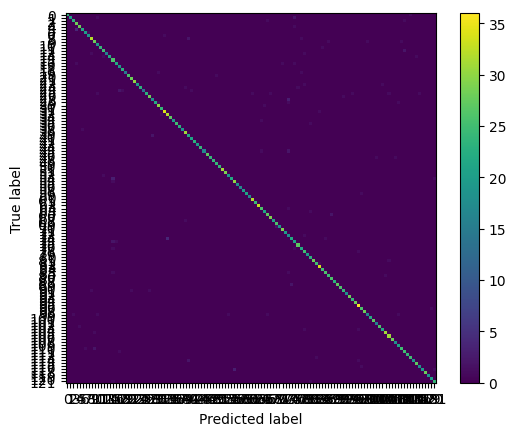

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

test_pm = np.array([1, 2, 3, 4, 5])
cm = confusion_matrix(y_actual, y_predict)
cmDisp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmDisp.plot(include_values=False)
plt.show()

## 5. Saving Model Weights

In [53]:
MODEL_PATH = os.path.join("../action-recognition/models")

In [95]:
model.save(os.path.join(MODEL_PATH, "model_v2_float16_1.h5"))